In [16]:
from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from IPython.display import HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette = "Set2")
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

styles = [
    hover(),
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

## SPAM FILTERING

Load data in .arff to pd.DataFrame (1.2)

In [3]:
data, _ = arff.loadarff('data/raw/spambase.arff.txt')
spambase = pd.DataFrame(data)

Drop columns (1.4)

In [4]:
spambase.drop(['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total'], 1, inplace=True)

Convert column types (1.5)

In [5]:
def numberic_to_bool(df, inplace=False):
    """
    convert columns with numerical dtypes to boolean
    """
    if not inplace:
        df = df.copy()
    num_cols = df.select_dtypes(float).columns
    df.loc[:, num_cols] = df.loc[:, num_cols].astype(bool).astype(int)
    return df

def object_to_str(df, inplace=False, str_to_bool=False):
    """
    convert columns with objects dtypes to str (or bool)
    """
    if not inplace:
        df = df.copy()
    if not str_to_bool:
        lmbd = lambda x: x.str
    else:
        lmbd = lambda x: x.str.decode("utf-8").astype(int)
    obj_cols = df.select_dtypes([np.object]).columns
    df.loc[:, obj_cols] = df.loc[:, obj_cols].apply(lmbd)
    return df

In [6]:
spambase = numberic_to_bool(spambase)

In [7]:
spambase = object_to_str(spambase, False, True)

Save data with bag of words (1.6)

In [8]:
spambase.to_csv('data/spambase_bag_of_words.csv', index=False)

## Train models

In [9]:
Y = spambase.pop('is_spam')
X = spambase

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [11]:
print("Train label:\nNumber of '0' values: {}".format(y_train.value_counts()[0]))
print("Number of '1' values: {}".format(y_train.value_counts()[1]))
print("Relation '1' to '0': {}\n".format(y_train.value_counts()[1]/y_train.value_counts()[0]))
print("Test label:\nNumber of '0' values: {}".format(y_test.value_counts()[0]))
print("Number of '1' values: {}".format(y_test.value_counts()[1]))
print("Relation '1' to '0': {}".format(y_test.value_counts()[1]/y_test.value_counts()[0]))

Train label:
Number of '0' values: 2525
Number of '1' values: 1615
Relation '1' to '0': 0.6396039603960396

Test label:
Number of '0' values: 263
Number of '1' values: 198
Relation '1' to '0': 0.752851711026616


### Logistic Regression

In [12]:
log_regr_model = LogisticRegression()
log_regr_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
log_regr_pred = log_regr_model.predict(x_test)

- What is the percentage of correctly classified instances?

In [14]:
log_regr_score = log_regr_model.score(x_test, y_test) # score = correct predictions / total number of data points
print('Score: {}'.format(log_regr_score))

Score: 0.9327548806941431


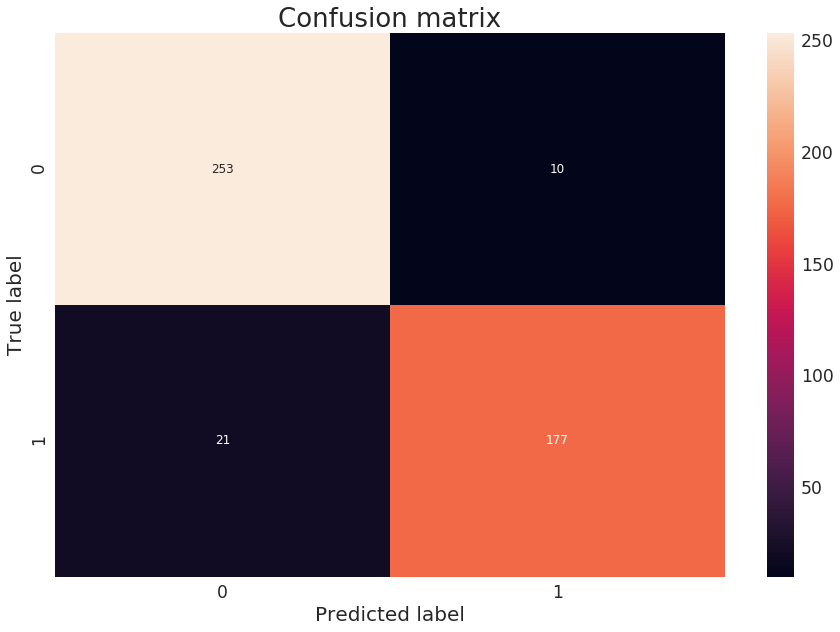

In [17]:
log_regr_conf_matrix = metrics.confusion_matrix(y_test, log_regr_pred)
sns.heatmap(log_regr_conf_matrix, annot=True, fmt="d")
plt.ylabel('True label', size=20)
plt.xlabel('Predicted label', size=20)
plt.title('Confusion matrix', size=26)
plt.show()

In [18]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

log_regr_prfs_score = metrics.precision_recall_fscore_support(y_test, log_regr_pred)
log_regr_df = pd.DataFrame(data={'Precision': log_regr_prfs_score[0], 'Recall': log_regr_prfs_score[1],
                                 'F1 score': log_regr_prfs_score[2], 'Support': log_regr_prfs_score[3]},
                           columns=['Precision', 'Recall', 'F1 score', 'Support'], index=[0, 1])

html = (log_regr_df.style.set_table_styles(styles).set_caption("Hover to highlight."))
html

,Precision,Recall,F1 score,Support
0,0.923358,0.961977,0.942272,263
1,0.946524,0.893939,0.919481,198


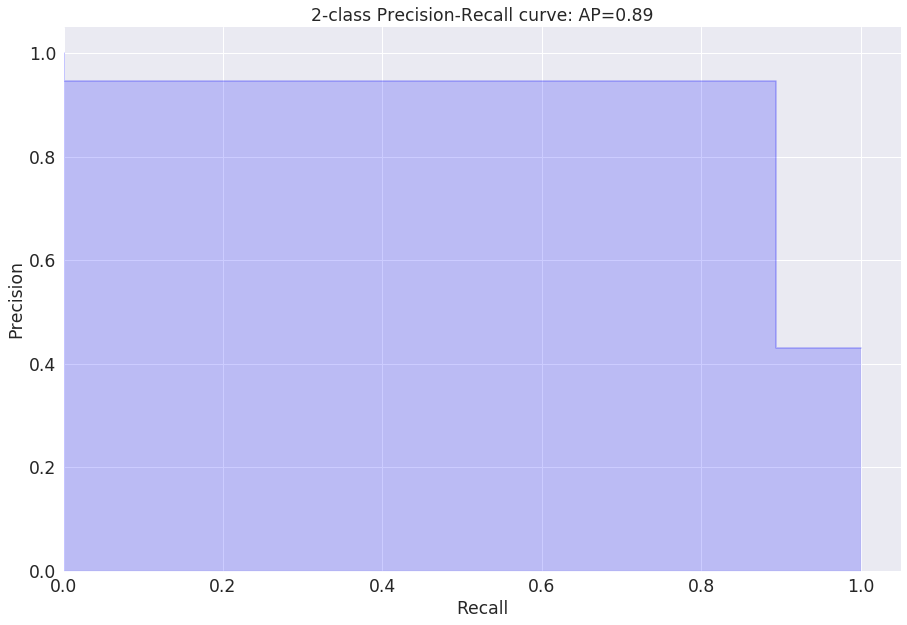

In [19]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

log_regr_average_precision = metrics.average_precision_score(y_test, log_regr_pred)
log_regr_precision, log_regr_recall, _ = metrics.precision_recall_curve(y_test, log_regr_pred)

plt.step(log_regr_recall, log_regr_precision, color='b', alpha=0.2, where='post')
plt.fill_between(log_regr_recall, log_regr_precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(log_regr_average_precision))
plt.show()

- How do the regression coefficients for class 1 relate to the ones for class 0?
Can you derive this result from the form of the Logistic Regression model?

In [20]:
log_regr_coef = log_regr_model.coef_[0]

In [21]:
# ??? How to calculate?
len(log_regr_coef[log_regr_coef > 0])/len(log_regr_coef[log_regr_coef < 0])

0.9285714285714286

- Write down the coefficients for class 1 for the
attributes **[word_freq_hp_binarized]** and **\[char_freq_\$_binarized\]**.
Generally, we would expect the string **$** to appear in spam, and the
string hp to appear in non-spam e-mails, as the data was collected from HP
Labs. Do the regression coefficients make sense given that class 1 is
spam? <br>
_Hint_: Consider the sigmoid function and how it transforms values into
a probability between 0 and 1. Since our attributes are boolean, a positive
coefficient can only increase the total sum fed through the sigmoid and thus
move the output of the sigmoid towards 1. What can happen if we have
continuous, real-valued attributes?

In [22]:
log_regr_word_freq_hp_coef = log_regr_coef[x_train.columns.get_loc('word_freq_hp')]
print('Coef equals {}  =>  not spam'.format(log_regr_word_freq_hp_coef))

Coef equals -2.710106678587926  =>  not spam


In [23]:
log_regr_char_freq_coef = log_regr_coef[x_train.columns.get_loc('char_freq_$')]
print('Coef equals {}  =>  spam'.format(log_regr_char_freq_coef))

Coef equals 1.6930235734119126  =>  spam


###  Support Vector Machine

In [24]:
from sklearn import svm
 

In [25]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
svm_pred = svm_model.predict(x_test)

- What is the percent of correctly classified instances? How does it compare to
the result from Logistic Regression?

In [27]:
svm_score = svm_model.score(x_test, y_test) # score = correct predictions / total number of data points
print('Score: {}'.format(svm_score))

Score: 0.9327548806941431


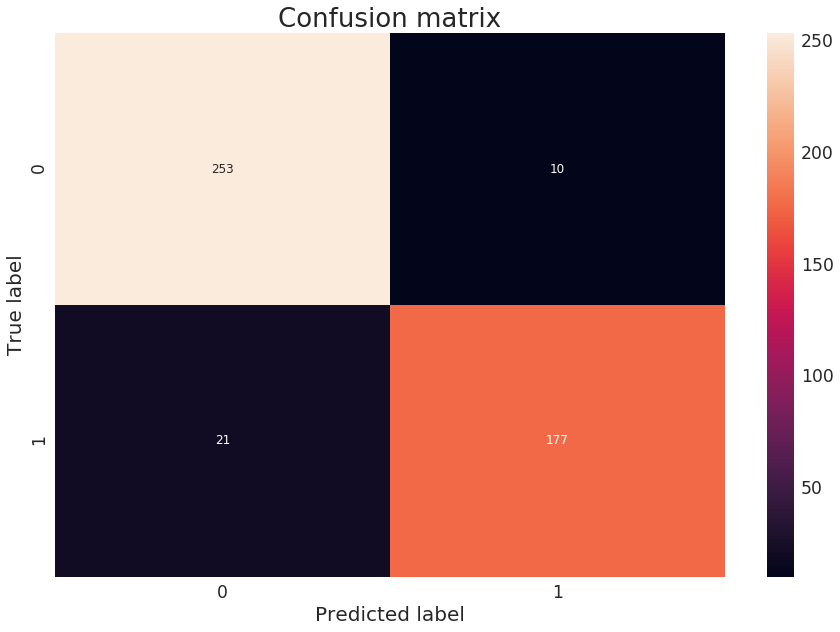

In [28]:
svm_conf_matrix = metrics.confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_conf_matrix, annot=True, fmt="d")
plt.ylabel('True label', size=20)
plt.xlabel('Predicted label', size=20)
plt.title('Confusion matrix', size=26)
plt.show()

In [29]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

svm_prfs_score = metrics.precision_recall_fscore_support(y_test, svm_pred)
svm_df = pd.DataFrame(data={'Precision': svm_prfs_score[0], 'Recall': svm_prfs_score[1], 
                            'F1 score': svm_prfs_score[2], 'Support': svm_prfs_score[3]},
                      columns=['Precision', 'Recall', 'F1 score', 'Support'], index=[0, 1])

html = (svm_df.style.set_table_styles(styles).set_caption("Hover to highlight."))
html

,Precision,Recall,F1 score,Support
0,0.923358,0.961977,0.942272,263
1,0.946524,0.893939,0.919481,198


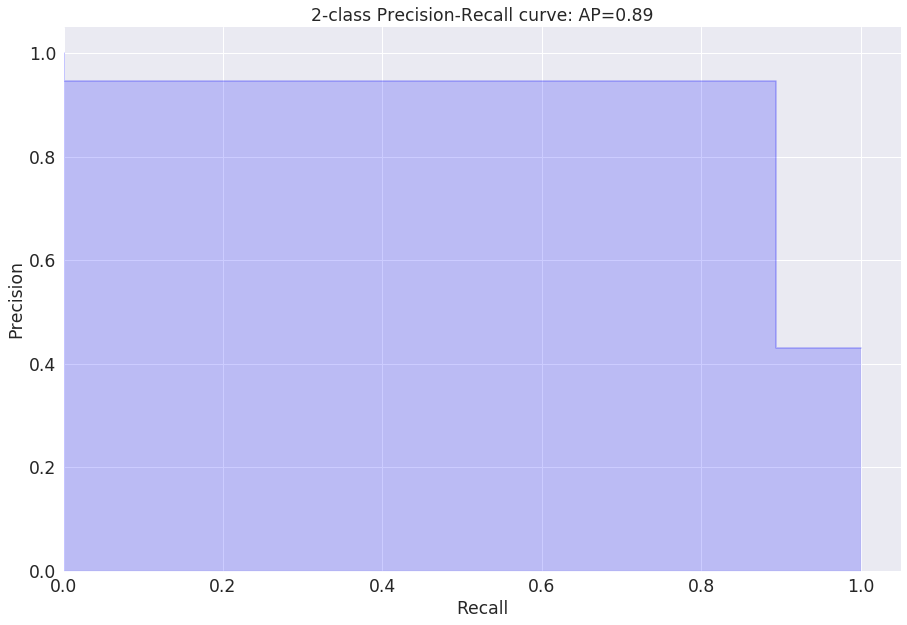

In [30]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

svm_average_precision = metrics.average_precision_score(y_test, svm_pred)
svm_precision, svm_recall, _ = metrics.precision_recall_curve(y_test, svm_pred)

plt.step(svm_recall, svm_precision, color='b', alpha=0.2, where='post')
plt.fill_between(svm_recall, svm_precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(svm_average_precision))
plt.show()

- What are the coefficients for the
attributes **[word_freq_hp_binarized]** and **[char_freq_$_binarized]**?
Compare these to the ones you found with Logistic Regression.

In [31]:
svm_coef = svm_model.coef_[0]

In [32]:
svm_word_freq_hp_coef = svm_coef[x_train.columns.get_loc('word_freq_hp')]
print('Coef equals {}  =>  not spam'.format(svm_word_freq_hp_coef))

Coef equals -2.104702653506182  =>  not spam


In [33]:
svm_char_freq_coef = svm_coef[x_train.columns.get_loc('char_freq_$')]
print('Coef equals {}  =>  spam'.format(svm_char_freq_coef))

Coef equals 1.2210970567459125  =>  spam


### Comparison 

In [34]:
log_regr_df = log_regr_df.assign(Model='Logistic Regression')
svm_df = svm_df.assign(Model='Support Vector Machine')

In [35]:
df = log_regr_df.append(svm_df)
df.index.name = 'Class'

In [36]:
comp_table = pd.pivot_table(df, index=['Model', 'Class'])
comp_table = comp_table.drop(['Support'], axis=1)
comp_table.index = comp_table.index.set_names([None, 'Class'])

In [37]:
coef_compar = pd.DataFrame(data={'Logistic Regression': [log_regr_word_freq_hp_coef, log_regr_char_freq_coef],
                                 'Support Vector Machine': [svm_word_freq_hp_coef, svm_char_freq_coef]}, index=['word_freq_hp', 'char_freq_$'])

In [38]:
metrics_table = (comp_table.T.style.set_table_styles(styles))
coef_table = (coef_compar.T.style.set_table_styles(styles))

In [39]:
metrics_table

In [40]:
coef_table

,word_freq_hp,char_freq_$
Logistic Regression,-2.71011,1.69302
Support Vector Machine,-2.1047,1.2211


- How does a linear SVM relate to Logistic Regression? <br>
_Hint_: Consider the
classification boundary learnt in each model.

For linear kernel, the decision boundary is y = w * x + b, the distance from point x to the decision boundary is y/||w||.

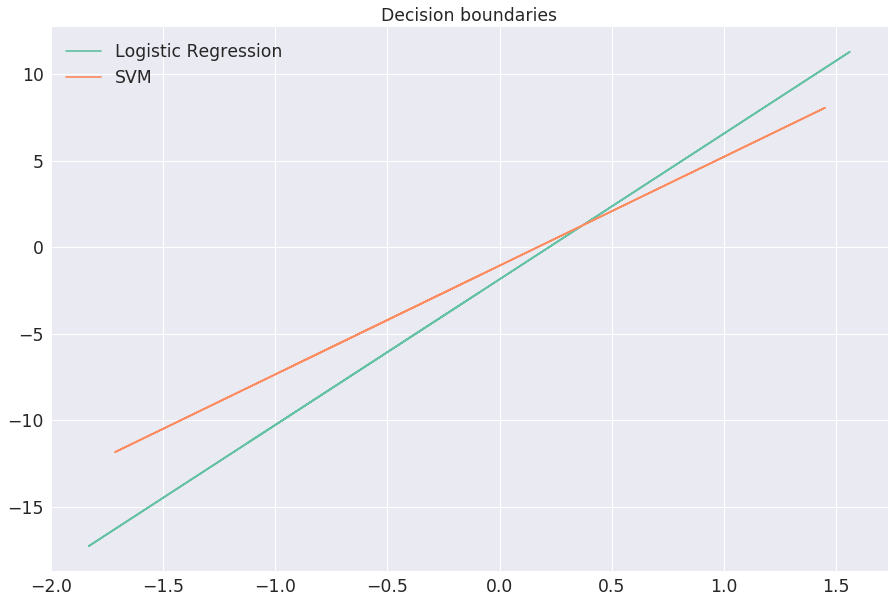

In [41]:
log_regr_y = log_regr_model.decision_function(x_train)
log_regr_w_norm = np.linalg.norm(log_regr_model.coef_)
log_regr_x = (log_regr_y - log_regr_model.intercept_)/ log_regr_w_norm

svm_y = svm_model.decision_function(x_train)
svm_w_norm = np.linalg.norm(svm_model.coef_)
svm_x = (svm_y - svm_model.intercept_)/ svm_w_norm

plt.plot(log_regr_x, log_regr_y, label='Logistic Regression')
plt.plot(svm_x, svm_y, label='SVM')
plt.title('Decision boundaries')
plt.legend()
plt.show()

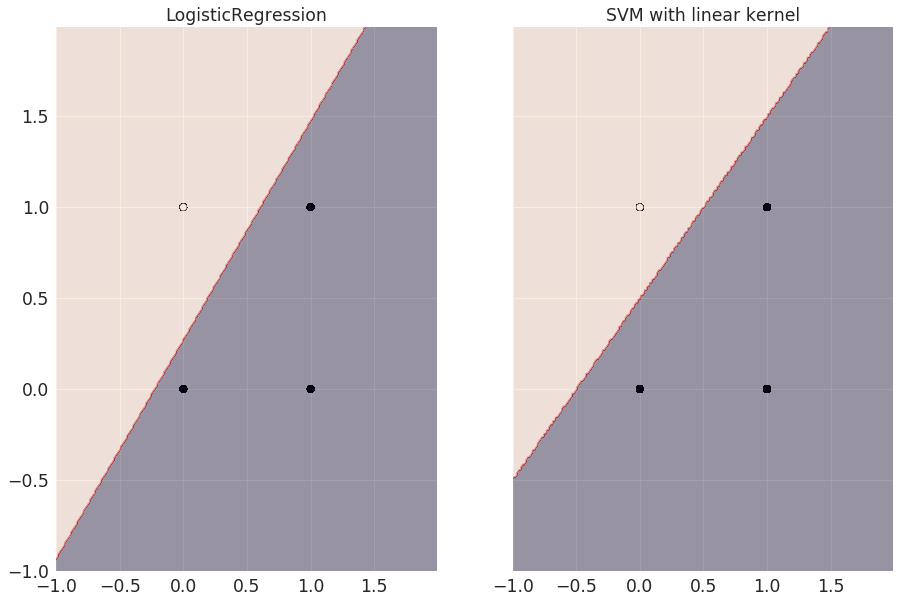

In [43]:
from itertools import product

X = np.array(x_train[['word_freq_hp', 'char_freq_$']])
y = np.array(y_train)

# Training classifiers
clf1 = LogisticRegression()
clf2 = svm.SVC(kernel='linear', probability=True)

clf1.fit(X, y)
clf2.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row')

for idx, clf, tt in zip(product([0, 1]), [clf1, clf2], ['LogisticRegression', 'SVM with linear kernel']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0]].scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
    axarr[idx[0]].set_title(tt)

plt.show()

##  PERFORMANCE ASSESSMENT #1

In [88]:
train, _ = arff.loadarff('data/raw/splice_train.arff.txt')
test, _ = arff.loadarff('data/raw/splice_test.arff.txt')

train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [89]:
train = [train[col].str.decode('utf-8') for col in train.columns]
train = pd.DataFrame(train).T

test = [test[col].str.decode('utf-8') for col in test.columns]
test = pd.DataFrame(test).T

In [90]:
data = train.append(test)
data = data.apply(lambda x: x.astype('category'))
data = data.apply(lambda x: x.cat.codes)

In [91]:
temp_train = data.iloc[:train.shape[0]]
temp_test = data.iloc[train.shape[0]:]

In [92]:
y_train = temp_train.pop('class')
x_train = temp_train
y_test = temp_test.pop('class')
x_test = temp_test

###  K-nearest neighbour

In [93]:
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

In [94]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

- What is the classification accuracy?

On train set:

In [95]:
knn_pred = knn_model.predict(x_train)

In [96]:
np.unique(y_train)

array([0, 1, 2], dtype=int8)

In [97]:
knn_score = knn_model.score(x_train, y_train) # score = correct predictions / total number of data points
print('Score: {}'.format(knn_score))

Score: 0.9996592844974447


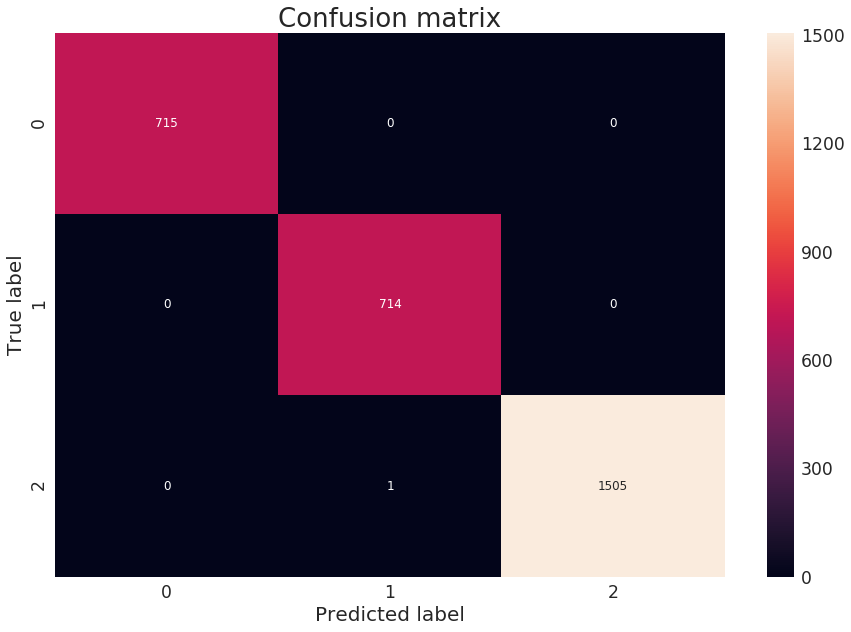

In [98]:
knn_conf_matrix = metrics.confusion_matrix(y_train, knn_pred)
sns.heatmap(knn_conf_matrix, annot=True, fmt="d")
plt.ylabel('True label', size=20)
plt.xlabel('Predicted label', size=20)
plt.title('Confusion matrix', size=26)
plt.show()

In [99]:
knn_prfs_score = metrics.precision_recall_fscore_support(y_train, knn_pred)
knn_df = pd.DataFrame(data={'Precision': knn_prfs_score[0], 'Recall': knn_prfs_score[1], 
                            'F1 score': knn_prfs_score[2], 'Support': knn_prfs_score[3]},
                      columns=['Precision', 'Recall', 'F1 score', 'Support'], index=[0, 1, 2])

html = (knn_df.style.set_table_styles(styles).set_caption("Hover to highlight."))
html

,Precision,Recall,F1 score,Support
0,1,1,1,715
1,0.998601,1,0.9993,714
2,1,0.999336,0.999668,1506


On test set:

In [100]:
knn_pred = knn_model.predict(x_test)

In [101]:
knn_score = knn_model.score(x_test, y_test) # score = correct predictions / total number of data points
print('Score: {}'.format(knn_score))

Score: 0.611764705882353


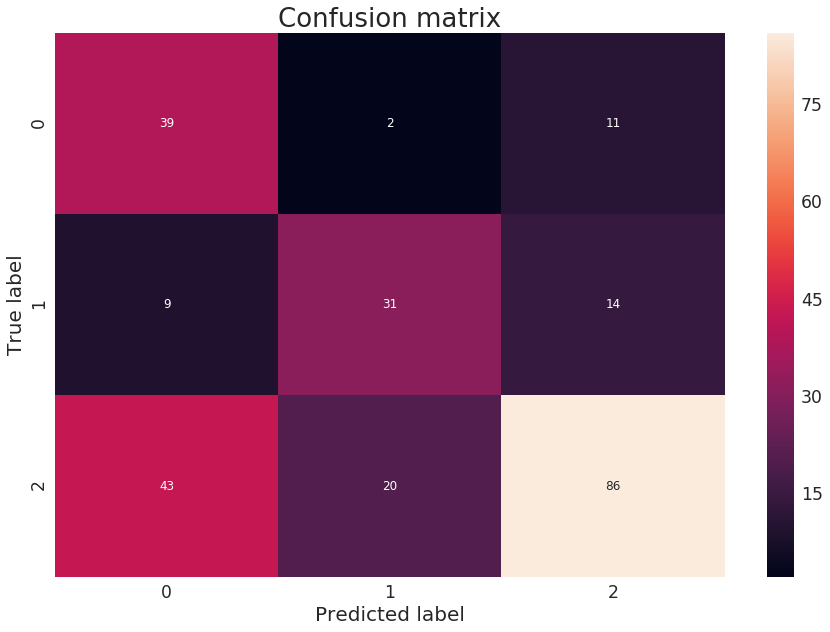

In [102]:
knn_conf_matrix = metrics.confusion_matrix(y_test, knn_pred)
sns.heatmap(knn_conf_matrix, annot=True, fmt="d")
plt.ylabel('True label', size=20)
plt.xlabel('Predicted label', size=20)
plt.title('Confusion matrix', size=26)
plt.show()

In [103]:
knn_prfs_score = metrics.precision_recall_fscore_support(y_test, knn_pred)
knn_df = pd.DataFrame(data={'Precision': knn_prfs_score[0], 'Recall': knn_prfs_score[1], 
                            'F1 score': knn_prfs_score[2], 'Support': knn_prfs_score[3]},
                      columns=['Precision', 'Recall', 'F1 score', 'Support'], index=[0, 1, 2])

html = (knn_df.style.set_table_styles(styles).set_caption("Hover to highlight."))
html

,Precision,Recall,F1 score,Support
0,0.428571,0.75,0.545455,52
1,0.584906,0.574074,0.579439,54
2,0.774775,0.577181,0.661538,149


- What would be the accuracy of the classifier, if all points were labelled as N? <br>
_Hint_: View the distribution of the class attribute of the test data. You can do
this by loading the test data on the Preprocess tab, and selecting
the class attribute in the Attributes panel.

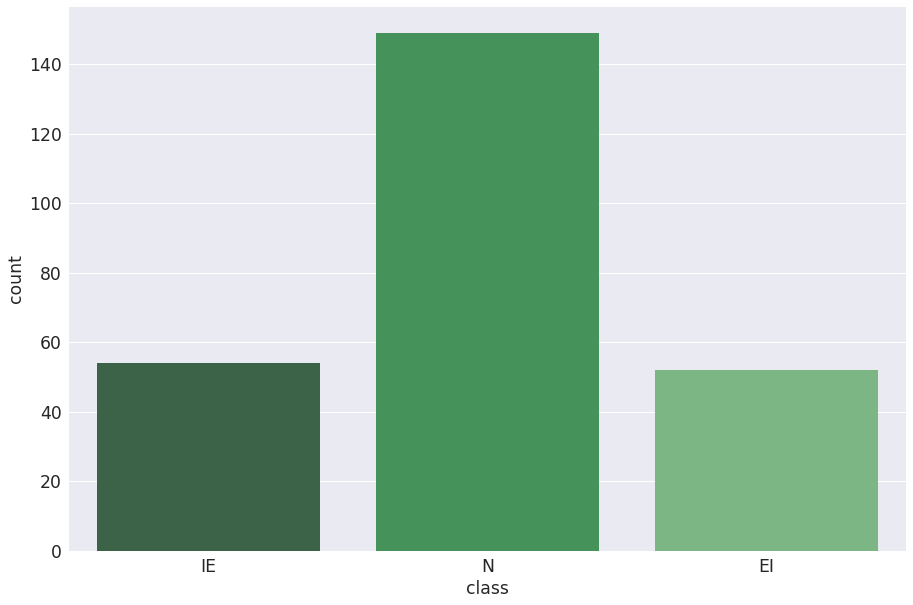

In [104]:
sns.countplot(x='class', data=test, palette="Greens_d");

Train KNN for 5, 10, 100, 1000 and 10000 neighbours.

In [110]:
stats = []
for i in [5, 10, 100, 1000]:
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_train, y_train)
    knn_pred = knn_model.predict(x_test)
    knn_score = knn_model.score(x_test, y_test) # score = correct predictions / total number of data points
    stats.append([i, knn_score])
    print('Neighbours amount: {}   Score: {}'.format(i, knn_score))
    knn_prfs_score = metrics.precision_recall_fscore_support(y_test, knn_pred)
    knn_df = pd.DataFrame(data={'Precision': knn_prfs_score[0], 'Recall': knn_prfs_score[1], 
                                'F1 score': knn_prfs_score[2], 'Support': knn_prfs_score[3]},
                          columns=['Precision', 'Recall', 'F1 score', 'Support'], index=[0, 1, 2])

    html = (knn_df.style.set_table_styles(styles))
    display(html)

Neighbours amount: 5   Score: 0.6431372549019608


,Precision,Recall,F1 score,Support
0,0.465347,0.903846,0.614379,52
1,0.591837,0.537037,0.563107,54
2,0.838095,0.590604,0.692913,149


Neighbours amount: 10   Score: 0.6549019607843137


,Precision,Recall,F1 score,Support
0,0.455357,0.980769,0.621951,52
1,0.666667,0.481481,0.55914,54
2,0.865385,0.604027,0.711462,149


Neighbours amount: 100   Score: 0.6627450980392157


,Precision,Recall,F1 score,Support
0,0.425,0.980769,0.593023,52
1,0.904762,0.351852,0.506667,54
2,0.868421,0.66443,0.752852,149


Neighbours amount: 1000   Score: 0.6941176470588235


,Precision,Recall,F1 score,Support
0,0.789474,0.576923,0.666667,52
1,1,0.0555556,0.105263,54
2,0.672897,0.966443,0.793388,149


- How does the k parameter effect the results? <br>
_Hint_: Consider how well the classifier is generalising to previously unseen data, and how it compares to the base rate again.

- Plot the results (k-value on the x-axis and PC on the y-axis), making sure to mark the axis. Can you conclude anything from observing the plot?

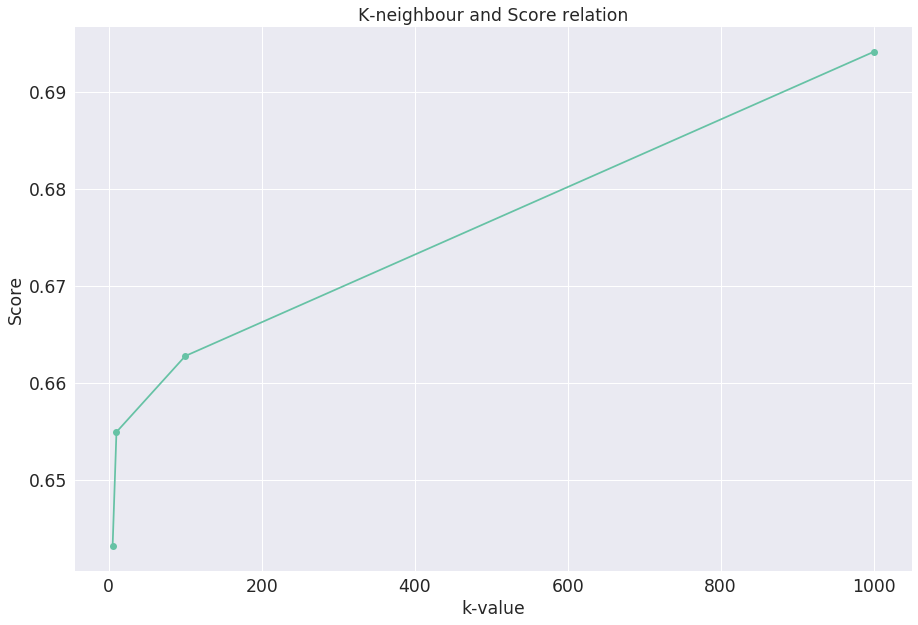

In [116]:
plt.plot(np.array(stats).T[0], np.array(stats).T[1], '-o')
plt.xlabel('k-value')
plt.ylabel('Score')
plt.title('K-neighbour and Score relation')
plt.show()